In [85]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import anndata
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 10

In [86]:
adata = anndata.read_h5ad("C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [107]:
# set your gene of interest (GOI) here:

GOI = "JCHAIN"
cell_type = 'Plasma'

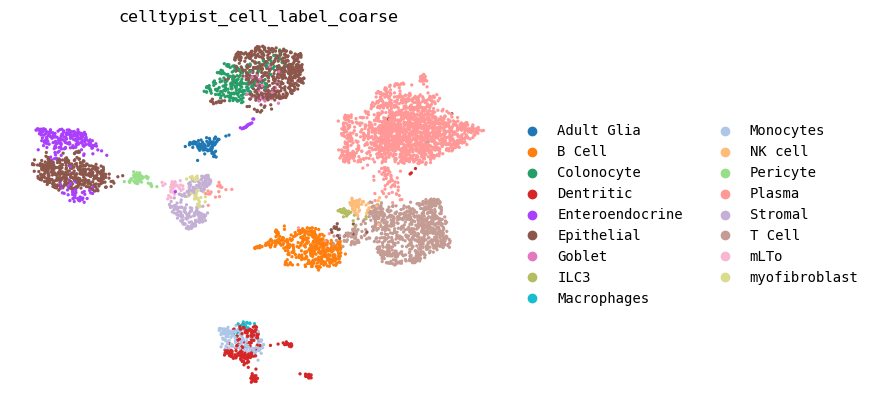

In [88]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse"],
    frameon=False,
)

In [138]:
def clean_data(df, col, threshold = 99.75):
    data = df[col].to_numpy().flatten()
    data = data[data <= np.percentile(data, threshold)]
    return data

def find_thresholds(filtered):
    range = (abs(max(filtered)) + abs(min(filtered)))
    step = range / float(4)
    very_low = min(filtered) + step
    low = min(filtered) + step*2
    middle = min(filtered) + step*3
    #print(round(very_low, 2), round(low, 2), round(middle, 2), round(max(filtered), 2))
    return very_low, low, middle, max(filtered)

def classify_exp_level(df, filtered, col, print_quantile = False, print_gene_num = False):
    very_low, low, middle, high = find_thresholds(filtered)
    def func(x):
        if x <= very_low:
            return "very_low"
        elif very_low < x <= low:
            return "low"
        elif low < x <= middle:
            return "middle"
        elif middle < x <= high:
            return "high"
        else:
            return "very_high"
    df['expr_class'] = df[col].apply(func)
    if print_quantile:
        print(str(round(stats.percentileofscore(df[col], very_low), 4)) + ", " + str(round(stats.percentileofscore(df[col], low), 4)) + ", " + 
              str(round(stats.percentileofscore(df[col], middle), 4)) + ", " + str(round(stats.percentileofscore(df[col], high), 4)) + ", 99.7500")
    if print_gene_num:
        print("Number of genes per category: ")
        print("very_low: " + str(len(df[df['expr_class'] == 'very_low'])))
        print("low: " + str(len(df[df['expr_class'] == 'low'])))
        print("middle: " + str(len(df[df['expr_class'] == 'middle'])))
        print("high: " + str(len(df[df['expr_class'] == 'high'])))
        print("very_high: " + str(len(df[df['expr_class'] == 'very_high'])))
    return df

def make_df(adata, col, print_quantile = False, print_gene_num = False):
    sc.pp.highly_variable_genes(adata, layer='log_norm')
    df = adata.var.sort_values(['means'])
    df['gene_num'] = range(len(df))
    df['log(means)'] = np.log(df['means'])
    df['log1p(means)'] = np.log1p(df['means'])

    filtered = clean_data(df, col=col, threshold=99.75) # can choose upper outlier threshold here
    df_new = classify_exp_level(df =df, filtered=filtered, col=col, print_quantile=print_quantile, print_gene_num = print_gene_num)
    return df_new

In [90]:
def explain_expr_celltypes(adata, col):
    print(GOI + " Expression across cell types: ")
    print("\t [cell type]; [expression classification]; [avg. expression over this cell type]")
    for cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
        subset = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        df = make_df(subset, col)
        print("\t " + cell_type + ";  " + str(df.loc[df.index == GOI]['expr_class'].values[0]) + ";  " + str(round(df.loc[df.index == GOI][col].values[0], 3)))


In [91]:
explain_expr_celltypes(adata, 'log1p(means)')

JCHAIN Expression across cell types: 
	 [cell type]; [expression classification]; [avg. expression over this cell type]


	 mLTo;  middle;  0.877
	 Monocytes;  very_low;  0.264
	 B Cell;  low;  0.593
	 Epithelial;  middle;  0.81
	 T Cell;  low;  0.542
	 Dentritic;  middle;  0.973
	 Plasma;  very_high;  1.889
	 Enteroendocrine;  very_low;  0.143
	 Colonocyte;  low;  0.729
	 myofibroblast;  very_low;  0.125
	 Stromal;  very_low;  0.342
	 Adult Glia;  high;  1.036
	 Pericyte;  low;  0.398
	 ILC3;  very_low;  0.138
	 NK cell;  middle;  1.01
	 Macrophages;  very_low;  0.112
	 Goblet;  high;  1.264


In [ ]:
# TODO threshold for expectring dropout zeros 

90.8188, 97.769, 99.0909, 99.7488, 99.7500
Number of genes per category: 
very_low: 15184
low: 1162
middle: 221
high: 110
very_high: 42


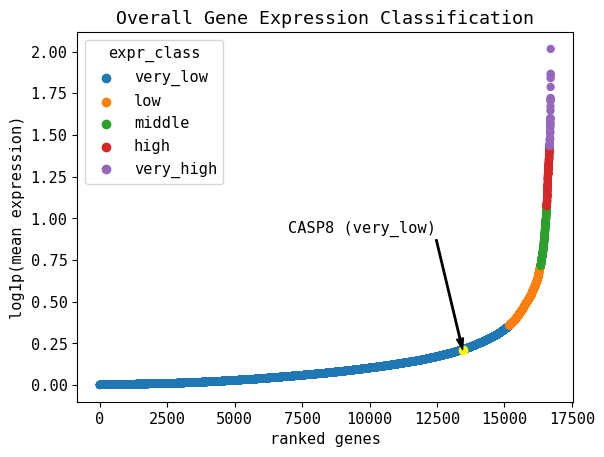

In [142]:
# find overall expression of all genes, highlighting GOI
#GOI = 'CASP8'
col = 'log1p(means)' 
df_new = make_df(adata, col, print_quantile=True, print_gene_num = True)

g = sns.scatterplot(data=df_new, x='gene_num',  y=col, hue='expr_class', linewidth=0)
annotation = str(GOI + " (" + df_new.loc[df_new.index == GOI]['expr_class'].values[0] + ")")
highlight_y = df_new.loc[df_new.index == GOI][col]
highlight_x = df_new.loc[df_new.index == GOI]['gene_num']
g.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
g.annotate(annotation, (highlight_x, highlight_y), (highlight_x - 1000, highlight_y+0.7), arrowprops=props, ha='right') #TODO make arrow go down if gene is very high on
g.set_title(str("Overall Gene Expression Classification"))
g.set_xlabel("ranked genes")
g.set_ylabel("log1p(mean expression)")
plt.show()

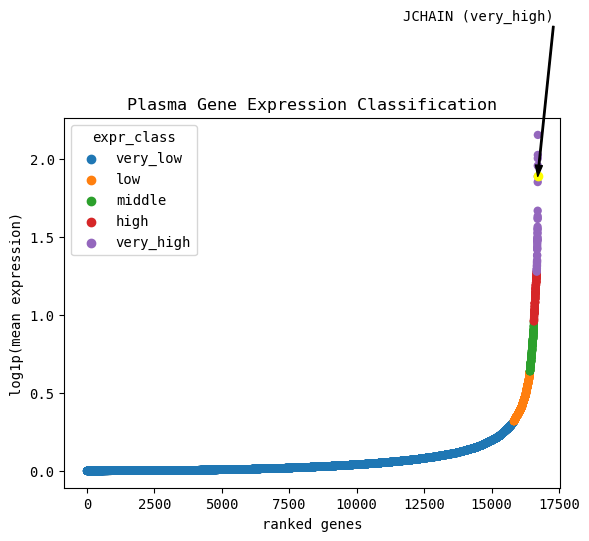

In [93]:
# find overall expression of all genes within cell type of interest, highlighting GOI

#cell_type = 'T Cell' #TODO: find this automatically? suggestion? input from user? for all of them? 
adata_sub = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]

col = 'log1p(means)' 
df_new = make_df(adata_sub, col)

g = sns.scatterplot(data=df_new, x='gene_num',  y=col, hue='expr_class', linewidth=0)
annotation = str(GOI + " (" + df_new.loc[df_new.index == GOI]['expr_class'].values[0] + ")")
highlight_y = df_new.loc[df_new.index == GOI][col]
highlight_x = df_new.loc[df_new.index == GOI]['gene_num']
g.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
g.annotate(annotation, (highlight_x, highlight_y), (highlight_x-5000, highlight_y+1), arrowprops=props)
g.set_title(str(cell_type + " Gene Expression Classification"))
g.set_xlabel("ranked genes")
g.set_ylabel("log1p(mean expression)")
plt.show()

In [94]:
plt.rcParams["font.size"] = 11

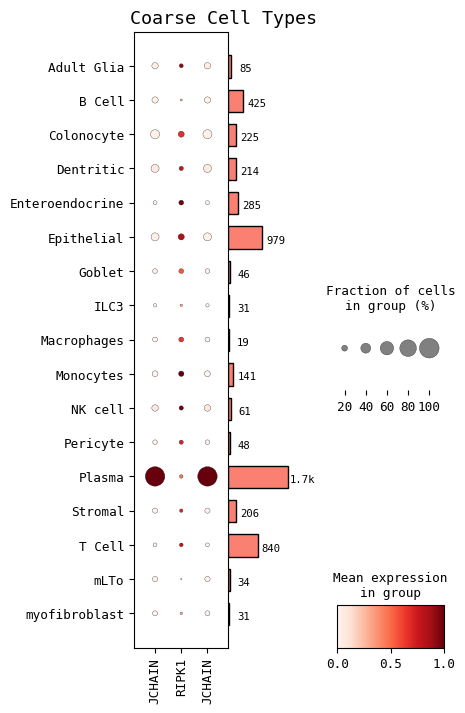

In [95]:
# find expression across cell types of GOI here

markers=[GOI, 'RIPK1']# TODO
ax1 = sc.pl.dotplot(adata, var_names=markers, groupby='celltypist_cell_label_coarse', return_fig=True, standard_scale='var', title="Coarse Cell Types", figsize=(4,8))
ax1.add_totals().show()

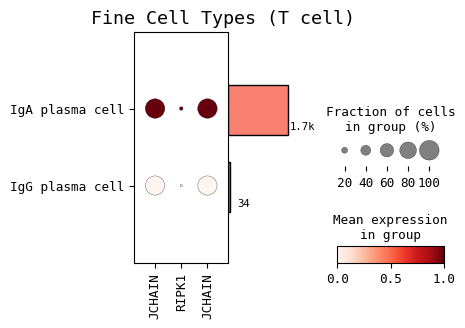

In [96]:
# TODO: zoom in AUTOMATICALLY on sub-cell types in cell type(s) where GOI is differentially expressed 

ax1 = sc.pl.dotplot(adata[adata.obs['celltypist_cell_label_coarse'] == cell_type], var_names=markers, groupby='celltypist_cell_label', 
                    return_fig=True, standard_scale='var', title='Fine Cell Types (T cell)', figsize=(4,3))
ax1.add_totals().show()

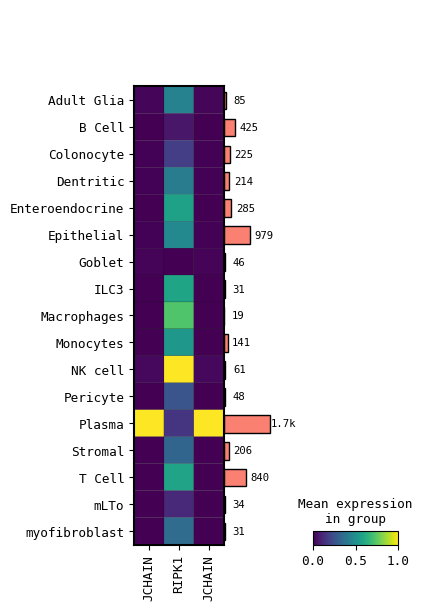

In [97]:
ax2 = sc.pl.matrixplot(adata, markers, groupby='celltypist_cell_label_coarse', return_fig=True, layer='log_int_norm', standard_scale='var')
ax2.add_totals().style(edge_color='black').show()

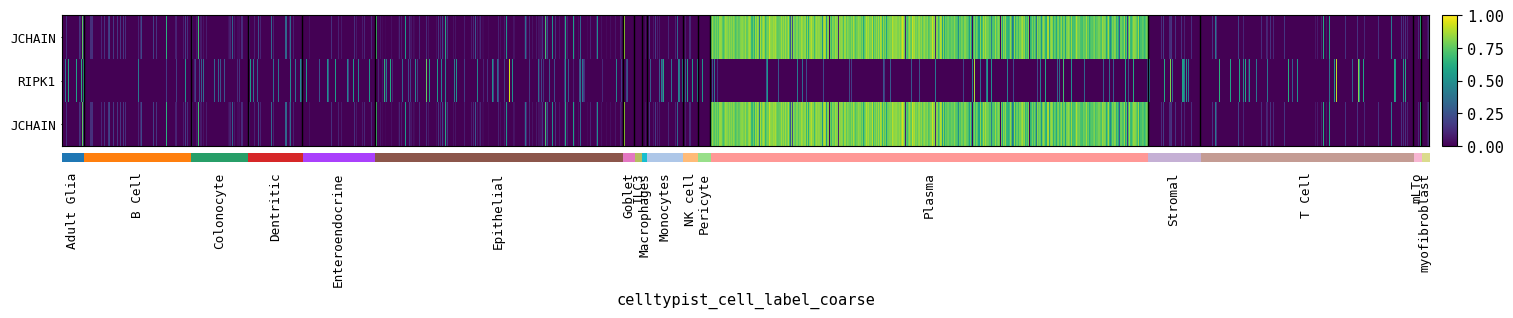

In [98]:
sc.pl.heatmap(adata, markers, groupby='celltypist_cell_label_coarse', swap_axes=True, figsize=(18,2), layer='log_norm', standard_scale='var')

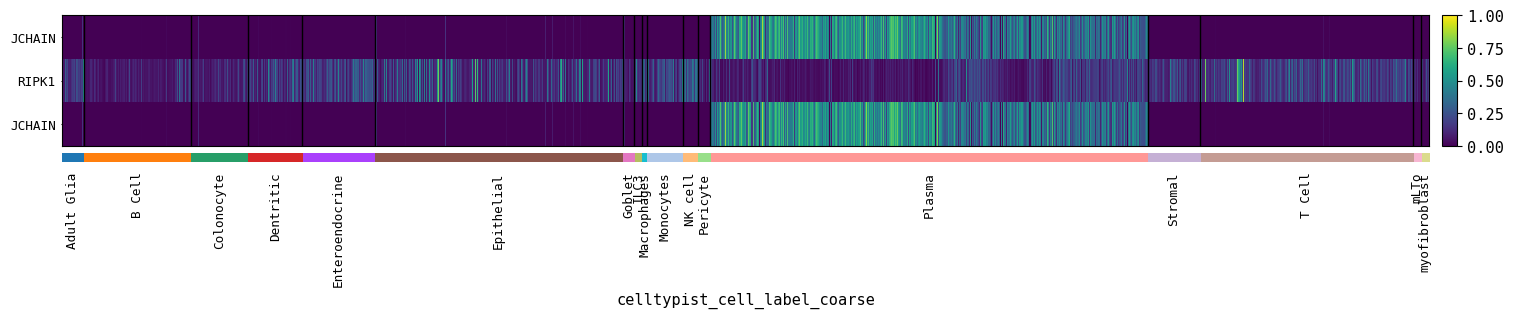

In [99]:
# heatmap with scvi normalized and logged values (sometimes shows a more clear cell type because of smoothing)
sc.pl.heatmap(adata, markers, groupby='celltypist_cell_label_coarse', swap_axes=True, figsize=(18,2), layer='log_int_norm', standard_scale='var')

In [129]:

# viz for overall expression of gene 
def plot_per_cell_type(adata, cell_type): #TODO make diff. boxes on same axes (hue = 'sample')
    data = adata[:, GOI]
    df = data.to_df(layer='log_norm')
    df['cell_type'] = data.obs['celltypist_cell_label_coarse']
    df['sample'] = data.obs['sampleID']

    df_cell = df[df['cell_type'] == cell_type]

    # Create a catplot with box plots
    ax1 = sns.catplot(data=df_cell, col='sample', kind='box', height=5, aspect=0.45)

    # Adjust the figure layout
    ax1.fig.subplots_adjust(top=0.8)
    ax1.fig.suptitle(str(GOI) + " Expression Across " + cell_type)

    # Calculate non-zero counts per sample
    non_zero_counts_per_sample = df_cell.groupby('sample')[GOI].apply(lambda x: (x != 0).sum())
    counter = 0
    # Add annotations for non-zero counts
    for ax in ax1.axes.flat:
        non_zero_counts = non_zero_counts_per_sample[counter]
        
        # Add the count as text annotation
        ax.text(0.5, -0.2, f'Non-zero count: {non_zero_counts}', 
                ha='center', va='center', transform=ax.transAxes)
        
        counter = counter + 1

# Show the plot
plt.show()


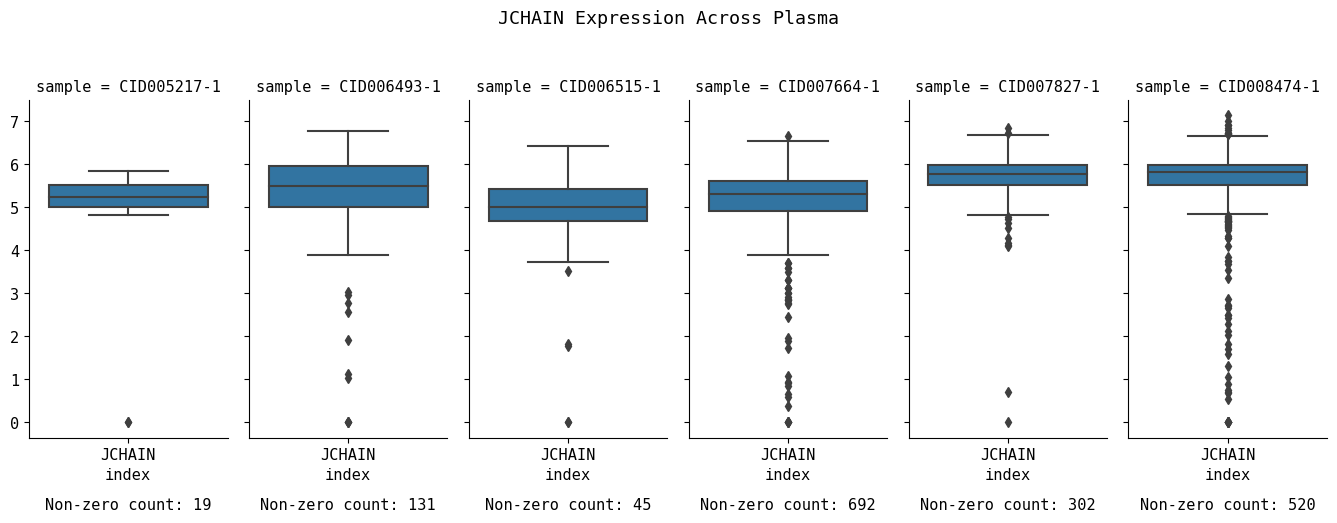

In [126]:
plot_per_cell_type(adata, cell_type=cell_type)

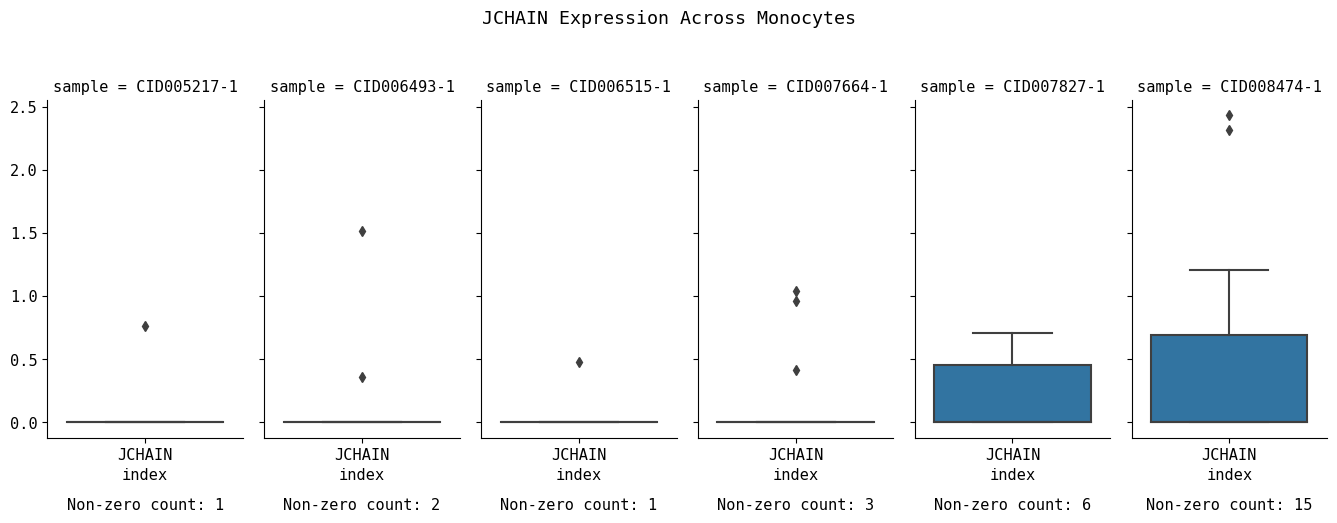

In [127]:
plot_per_cell_type(adata, "Monocytes")

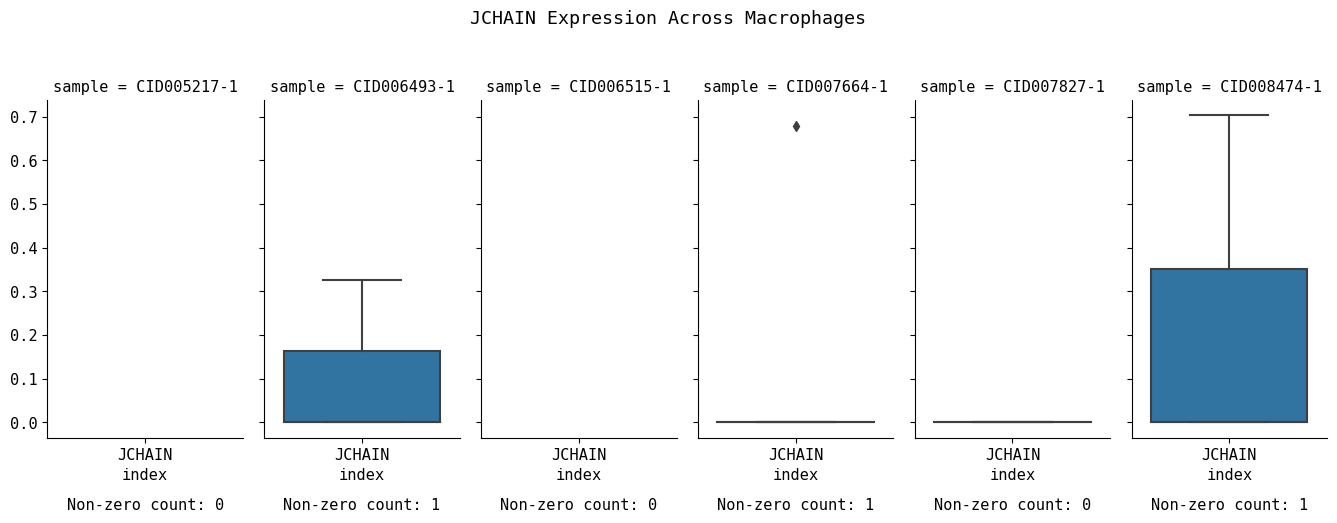

In [128]:
plot_per_cell_type(adata, "Macrophages")